<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Input, LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
# Necessário para o modelo Transformer
!pip install -U "tensorflow-text==2.14.*"
import tensorflow_text as tf_text

## Configurações

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [4]:
SEMENTE = 42

LIMITE_DICIONARIO = 90000

MAXIMO_MODELOS = 7

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 256
NUCLEO_CONV = 5
NUCLEO_SAIDA = 32
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.0005
METRICAS    = ['accuracy']

ITERACOES = 3
ITERACOES_MLP = 20

## Dados

In [5]:
dados = pd.read_csv('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv',
                    sep=';')

In [6]:
dados = dados[dados['noticias'].notna()]

In [7]:
dados['palavras'] = dados['noticias'].str.split().str.len()

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10738 entries, 0 to 10757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   noticias  10738 non-null  object
 1   classe    10738 non-null  int64 
 2   palavras  10738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 335.6+ KB


In [9]:
dados

,noticias,classe,palavras
0,katia abreu diz vai colocar expulsao moldura n...,0,99
1,ray peita bolsonaro conservador fake entrevist...,0,143
2,reinaldo azevedo desmascarado policia federal ...,0,153
3,relatorio assustador bndes mostra dinheiro pub...,0,339
4,radialista americano fala sobre pt vendem ilus...,0,66
...,...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0,50
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0,59
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0,56
10756,Estudo do pesquisador Karl Friston conclui que...,0,14


In [10]:
dados['classe'].value_counts()

0    6128
1    4610
Name: classe, dtype: int64

In [11]:
X = dados['noticias']
y = dados['classe']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEMENTE, stratify=y_train_val)

### Converter texto em números

In [12]:
# Quantidade máxima de palavras em 99% das notícias.
palavras_99 = int(np.percentile(dados['palavras'], 99))

print(f"Máximo.: {np.max(dados['palavras'])}")
print(f"Média..: {np.mean(dados['palavras'])}")
print(f"99%....: {palavras_99}")

Máximo.: 4229
Média..: 256.1611100763643
99%....: 1453


In [13]:
tamanho_texto = palavras_99

#### Vetorização (Vectorization)

In [14]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [15]:
vetorizador.adapt(X)

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
# len(vocabulario), vocabulario[:10], vocabulario[-10:]

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=256,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

## Funções

In [19]:
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome):
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)
    return Model(text_input, net, name=modelos_nome[modelo_numero])

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.xlabel('Época')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acurácia': relatorio['accuracy'],
            'precisão': relatorio['weighted avg']['precision'],
            'revocação': relatorio['weighted avg']['recall'],
            'pontuação-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice, X_val=X_val):
    avaliacoes[indice] = modelos[indice].evaluate(X_val, y_val)
    probabilidades[indice] = modelos[indice].predict(X_val)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_val, previsoes[indice])

def teste_modelo(indice, X_test=X_test):
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice])

## Modelos

In [20]:
modelos_nome = [None] * MAXIMO_MODELOS

modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [21]:
%%time

modelo_numero = 0

modelos_nome[modelo_numero] = 'TF-IDF'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

CPU times: user 2.29 s, sys: 40.3 ms, total: 2.33 s
Wall time: 2.4 s


Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_val)

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1103
           1       0.60      0.79      0.68       830

    accuracy                           0.68      1933
   macro avg       0.69      0.69      0.68      1933
weighted avg       0.71      0.68      0.68      1933



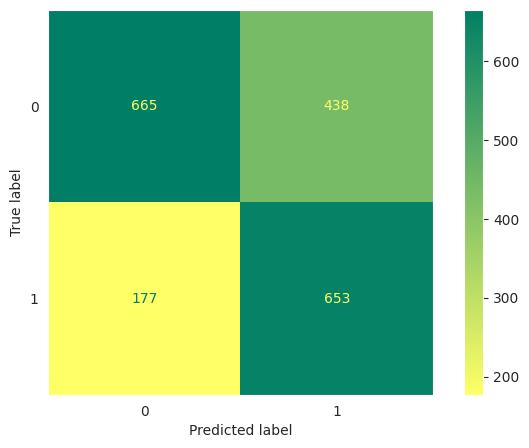

In [23]:
relatorios[modelo_numero] = avaliar_modelo(y_val, previsoes[modelo_numero])

In [24]:
relatorios[modelo_numero]

{'acurácia': 0.6818416968442835,
 'precisão': 0.7076652728288632,
 'revocação': 0.6818416968442835,
 'pontuação-f1': 0.6821083937915633}

### Camadas iniciais padronizadas

In [25]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 50.3 ms, sys: 1.04 ms, total: 51.4 ms
Wall time: 51.6 ms


### Modelo 1: MLP

In [26]:
%%time

modelo_numero = 1

modelos_nome[modelo_numero] = 'MLP'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES_MLP,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/20
242/242 [==============================] - 44s 160ms/step - loss: 0.6339 - accuracy: 0.7626 - val_loss: 0.5602 - val_accuracy: 0.8650
Epoch 2/20
242/242 [==============================] - 25s 105ms/step - loss: 0.4634 - accuracy: 0.8771 - val_loss: 0.4028 - val_accuracy: 0.8764
Epoch 3/20
242/242 [==============================] - 24s 99ms/step - loss: 0.3203 - accuracy: 0.8864 - val_loss: 0.3192 - val_accuracy: 0.8826
Epoch 4/20
242/242 [==============================] - 22s 90ms/step - loss: 0.2330 - accuracy: 0.9098 - val_loss: 0.2738 - val_accuracy: 0.8893
Epoch 5/20
242/242 [==============================] - 23s 95ms/step - loss: 0.1728 - accuracy: 0.9452 - val_loss: 0.2467 - val_accuracy: 0.8991
Epoch 6/20
242/242 [==============================] - 18s 73ms/step - loss: 0.1293 - accuracy: 0.9662 - val_loss: 0.2298 - val_accuracy: 0.8996
Epoch 7/20
242/242 [==============================] - 17s 69ms/step - loss: 0.0979 - accuracy: 0.9785 - val_loss: 0.2186 - val_accurac

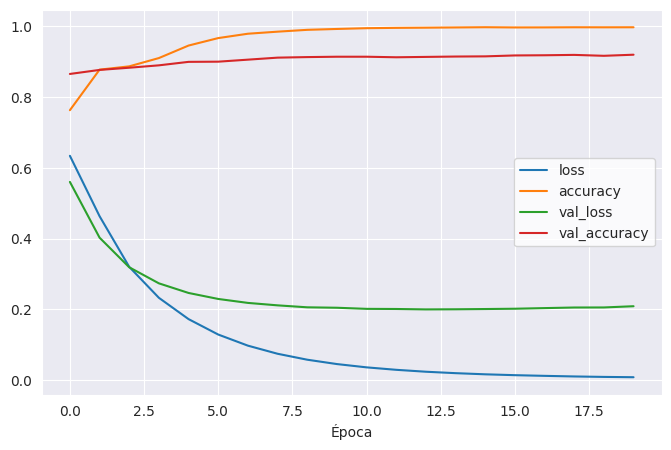

In [27]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1103
           1       0.94      0.86      0.90       830

    accuracy                           0.92      1933
   macro avg       0.92      0.91      0.92      1933
weighted avg       0.92      0.92      0.92      1933



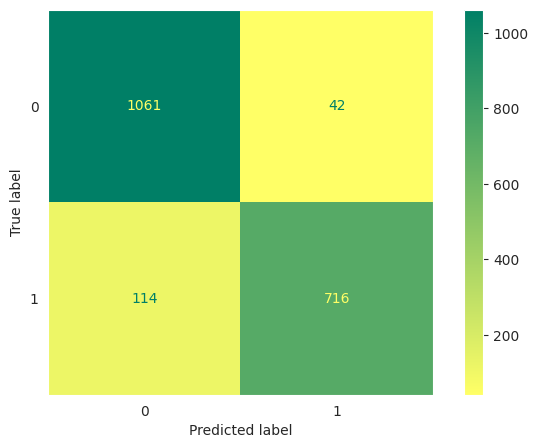

In [28]:
dados_modelo(modelo_numero)

In [29]:
relatorios[modelo_numero]

{'acurácia': 0.9192964304190377,
 'precisão': 0.9208463973122626,
 'revocação': 0.9192964304190377,
 'pontuação-f1': 0.918742264111262}

### Modelo 2: CNN

In [30]:
%%time

modelo_numero = 2

modelos_nome[modelo_numero] = 'RNC'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_CONV,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 33s 126ms/step - loss: 0.3342 - accuracy: 0.8668 - val_loss: 0.2849 - val_accuracy: 0.8852
Epoch 2/3
242/242 [==============================] - 29s 118ms/step - loss: 0.0775 - accuracy: 0.9767 - val_loss: 0.2952 - val_accuracy: 0.8877
Epoch 3/3
242/242 [==============================] - 26s 109ms/step - loss: 0.0184 - accuracy: 0.9952 - val_loss: 0.3874 - val_accuracy: 0.8645
CPU times: user 1min 20s, sys: 2.02 s, total: 1min 22s
Wall time: 2min 22s


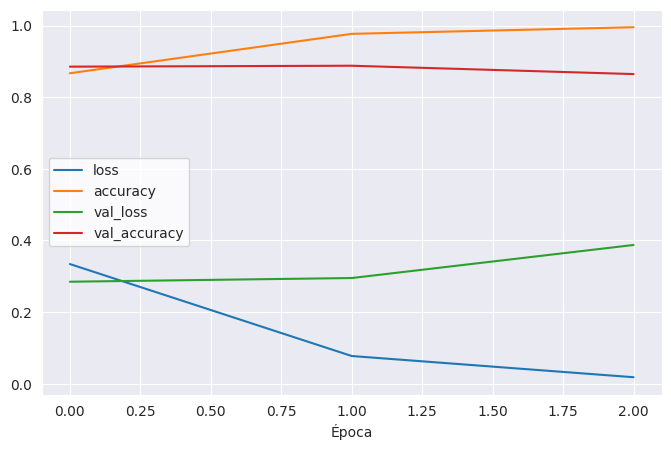

In [31]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1103
           1       0.80      0.91      0.85       830

    accuracy                           0.86      1933
   macro avg       0.86      0.87      0.86      1933
weighted avg       0.87      0.86      0.87      1933



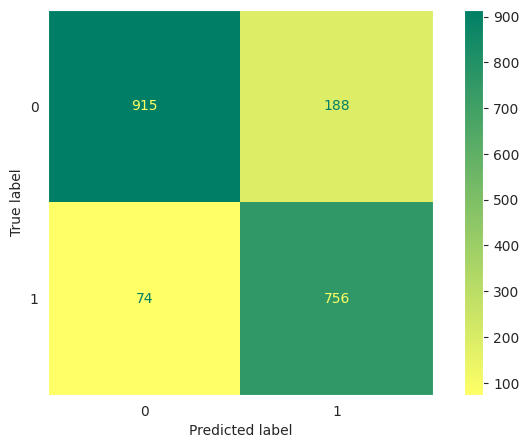

In [32]:
dados_modelo(modelo_numero)

In [33]:
relatorios[modelo_numero]

{'acurácia': 0.8644593895499224,
 'precisão': 0.8717918063741888,
 'revocação': 0.8644593895499224,
 'pontuação-f1': 0.8651213866961395}

### Modelo 3: DCNN

In [34]:
%%time

modelo_numero = 3

modelos_nome[modelo_numero] = 'CFN-AI'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 40s 152ms/step - loss: 0.0782 - accuracy: 0.9684 - val_loss: 0.5404 - val_accuracy: 0.8608
Epoch 2/3
242/242 [==============================] - 32s 134ms/step - loss: 0.0073 - accuracy: 0.9966 - val_loss: 0.6084 - val_accuracy: 0.8536
Epoch 3/3
242/242 [==============================] - 31s 126ms/step - loss: 0.0067 - accuracy: 0.9968 - val_loss: 0.6456 - val_accuracy: 0.8464
CPU times: user 1min 27s, sys: 2.13 s, total: 1min 29s
Wall time: 1min 43s


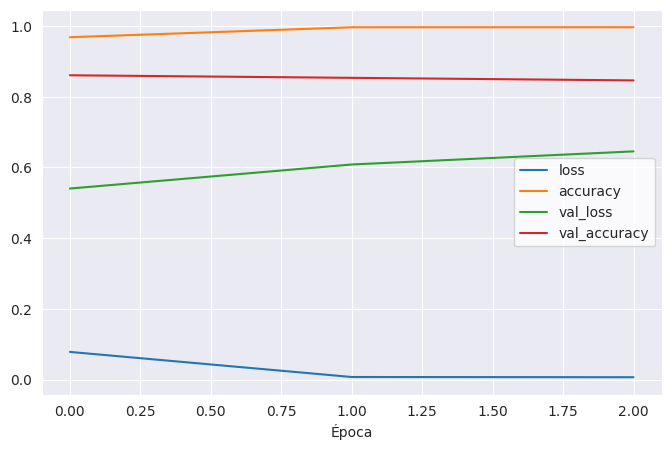

In [35]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1103
           1       0.80      0.86      0.83       830

    accuracy                           0.85      1933
   macro avg       0.84      0.85      0.84      1933
weighted avg       0.85      0.85      0.85      1933



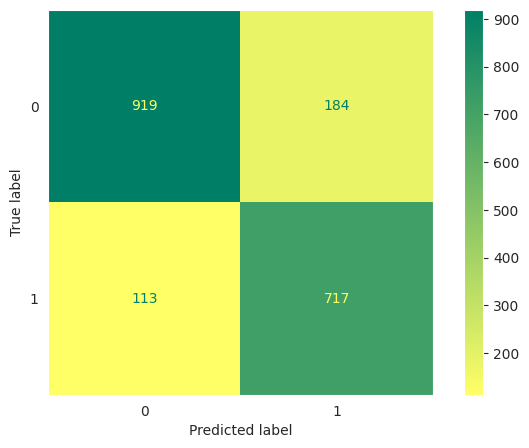

In [36]:
dados_modelo(modelo_numero)

In [37]:
relatorios[modelo_numero]

{'acurácia': 0.8463528194516295,
 'precisão': 0.8498319815079367,
 'revocação': 0.8463528194516295,
 'pontuação-f1': 0.8469490845184373}

### Modelo 4: RNN (LSTM Bidirecional)

In [38]:
%%time

modelo_numero = 4

modelos_nome[modelo_numero] = 'RNR'

camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA * 2,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 45s 333ms/step - loss: 0.4207 - accuracy: 0.7893 - val_loss: 0.5796 - val_accuracy: 0.6824
Epoch 2/3
121/121 [==============================] - 41s 339ms/step - loss: 0.1904 - accuracy: 0.9414 - val_loss: 0.3237 - val_accuracy: 0.8867
Epoch 3/3
121/121 [==============================] - 41s 338ms/step - loss: 0.0787 - accuracy: 0.9780 - val_loss: 0.3664 - val_accuracy: 0.8903
CPU times: user 1min 43s, sys: 17.2 s, total: 2min
Wall time: 2min 26s


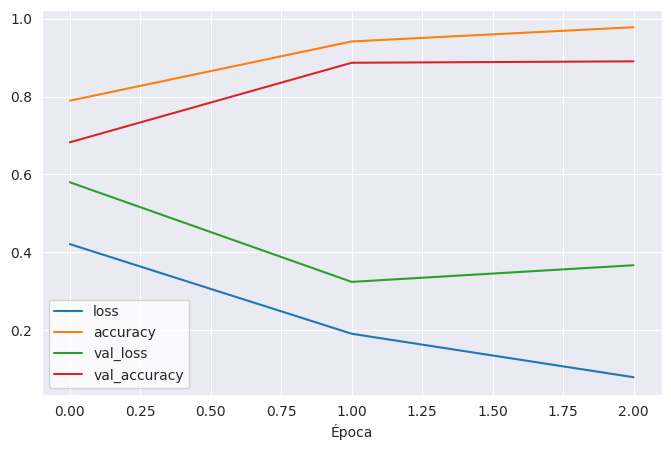

In [39]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 5s 63ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1103
           1       0.88      0.87      0.87       830

    accuracy                           0.89      1933
   macro avg       0.89      0.89      0.89      1933
weighted avg       0.89      0.89      0.89      1933



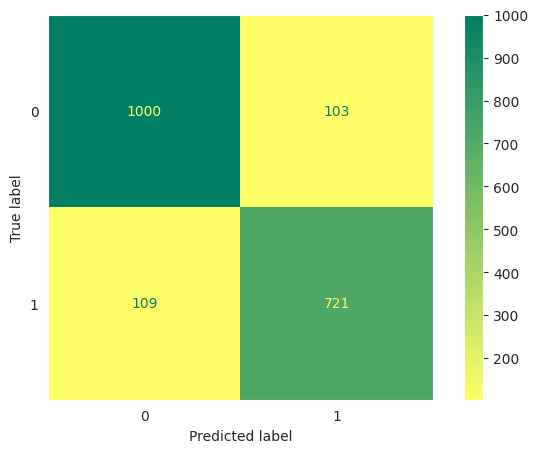

In [40]:
dados_modelo(modelo_numero)

In [41]:
relatorios[modelo_numero]

{'acurácia': 0.8903259182617693,
 'precisão': 0.8902430007599021,
 'revocação': 0.8903259182617693,
 'pontuação-f1': 0.8902757373171063}

### Modelo 5: Transformer

In [42]:
%%time

modelo_numero = 5

modelos_nome[modelo_numero] = 'Transformer'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'

modelos[modelo_numero] = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 65s 230ms/step - loss: 0.5716 - accuracy: 0.7017 - val_loss: 0.4740 - val_accuracy: 0.7750
Epoch 2/3
242/242 [==============================] - 41s 171ms/step - loss: 0.4045 - accuracy: 0.8202 - val_loss: 0.4186 - val_accuracy: 0.8039
Epoch 3/3
242/242 [==============================] - 43s 179ms/step - loss: 0.2992 - accuracy: 0.8691 - val_loss: 0.4446 - val_accuracy: 0.8065
CPU times: user 2min 41s, sys: 12.9 s, total: 2min 54s
Wall time: 3min 31s


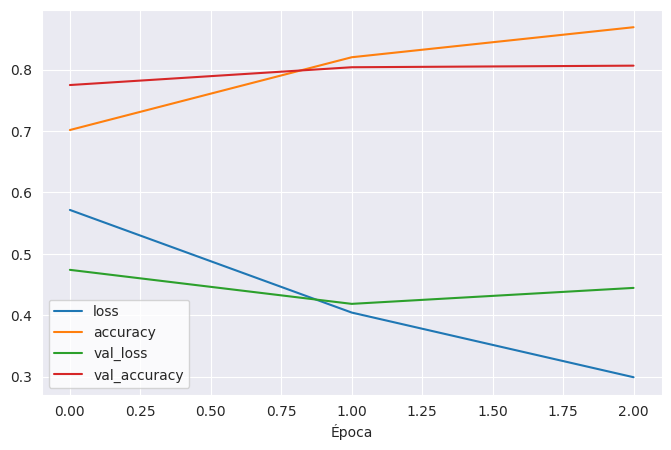

In [43]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 6s 97ms/step
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1103
           1       0.76      0.81      0.78       830

    accuracy                           0.81      1933
   macro avg       0.80      0.81      0.80      1933
weighted avg       0.81      0.81      0.81      1933



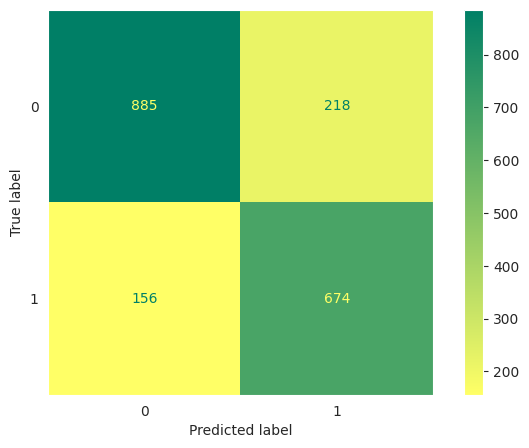

In [44]:
dados_modelo(modelo_numero)

In [45]:
relatorios[modelo_numero]

{'acurácia': 0.8065183652353854,
 'precisão': 0.809550646707342,
 'revocação': 0.8065183652353854,
 'pontuação-f1': 0.8072039418021353}

### Modelo 6: fakeDETECTOR

In [46]:
%%time

modelo_numero = 6

modelos_nome[modelo_numero] = 'fakeD'

train_texts = X_train.astype(str)
val_texts = X_val.astype(str)
test_texts = X_test.astype(str)

max_sequence_length = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

val_sequences = tokenizer.texts_to_sequences(val_texts)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

modelos[modelo_numero] = Sequential()

modelos[modelo_numero].add(Embedding((len(tokenizer.word_index) + 1), 200, input_length=max_sequence_length))

modelos[modelo_numero].add(Conv1D(ESPACO_SAIDA, NUCLEO_CONV, activation=ATIVACAO_CNN))

modelos[modelo_numero].add(GlobalMaxPool1D())

modelos[modelo_numero].add(Dense(ESPACO_SAIDA, activation=ATIVACAO_CNN))

modelos[modelo_numero].add(Dense(1, activation=ATIVACAO_SAIDA))

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=train_sequences,
                                                       y=y_train,
                                                       epochs=ITERACOES,
                                                       batch_size=NUCLEO_SAIDA,
                                                       validation_data=(val_sequences, y_val),
                                                       verbose=1)

Epoch 1/3
242/242 [==============================] - 46s 185ms/step - loss: 0.3656 - accuracy: 0.8428 - val_loss: 0.2524 - val_accuracy: 0.8924
Epoch 2/3
242/242 [==============================] - 41s 171ms/step - loss: 0.0885 - accuracy: 0.9686 - val_loss: 0.2312 - val_accuracy: 0.9074
Epoch 3/3
242/242 [==============================] - 36s 150ms/step - loss: 0.0144 - accuracy: 0.9947 - val_loss: 0.2649 - val_accuracy: 0.9131
CPU times: user 1min 20s, sys: 1.79 s, total: 1min 22s
Wall time: 2min 25s


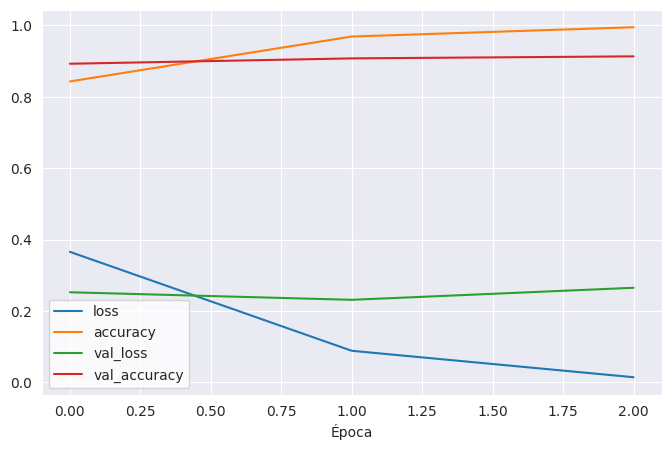

In [47]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1103
           1       0.93      0.86      0.89       830

    accuracy                           0.91      1933
   macro avg       0.92      0.91      0.91      1933
weighted avg       0.91      0.91      0.91      1933



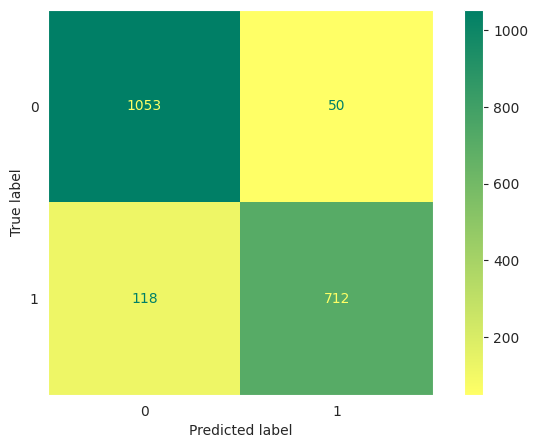

In [48]:
dados_modelo(modelo_numero, val_sequences)

In [49]:
relatorios[modelo_numero]

{'acurácia': 0.9130884635281945,
 'precisão': 0.9143250495425966,
 'revocação': 0.9130884635281945,
 'pontuação-f1': 0.9125317815066897}

## Comparar modelos

In [50]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

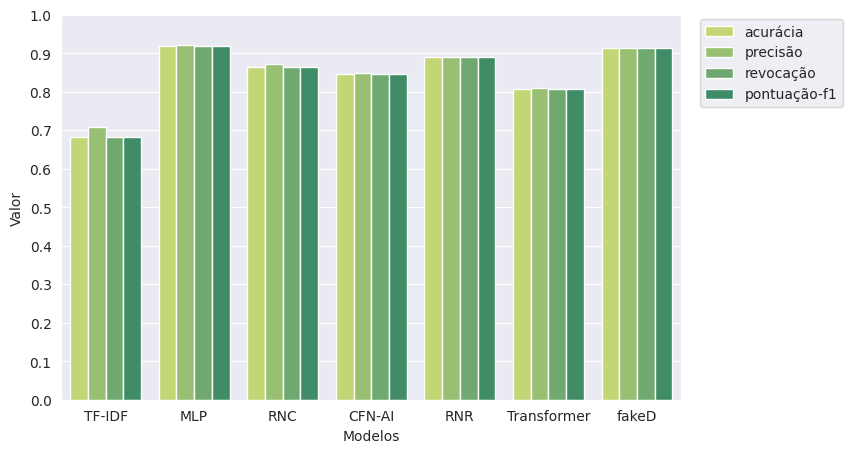

In [51]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

# plt.title('Medidas de avaliação dos modelos - Dados de validação')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

plt.legend(loc=(1.03, 0.76));

## Teste modelos

              precision    recall  f1-score   support

           0       0.80      0.63      0.70       613
           1       0.61      0.79      0.69       461

    accuracy                           0.69      1074
   macro avg       0.70      0.71      0.69      1074
weighted avg       0.72      0.69      0.70      1074

TF-IDF: 
{'acurácia': 0.6945996275605214, 'precisão': 0.7166911431006447, 'revocação': 0.6945996275605214, 'pontuação-f1': 0.6953571740701041}
34/34 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       613
           1       0.93      0.89      0.91       461

    accuracy                           0.92      1074
   macro avg       0.93      0.92      0.92      1074
weighted avg       0.92      0.92      0.92      1074

MLP: 
{'acurácia': 0.9245810055865922, 'precisão': 0.9246713193640569, 'revocação': 0.9245810055865922, 'pontuação-f1': 0.9243883876812842}
34/34 [===

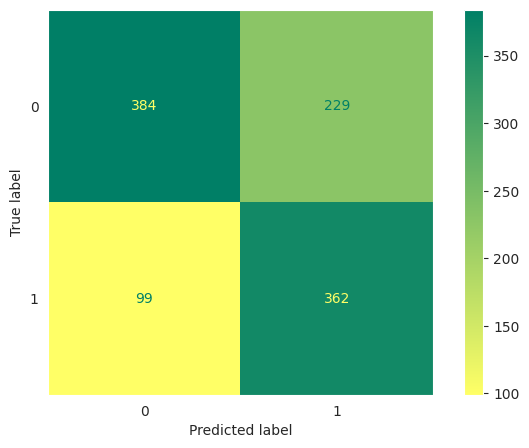

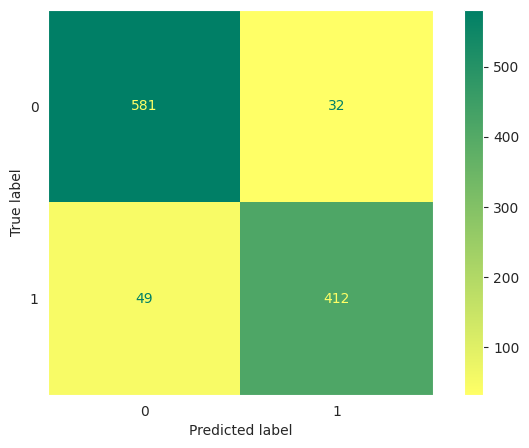

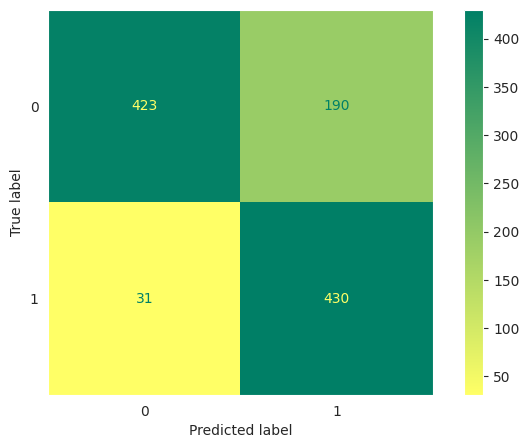

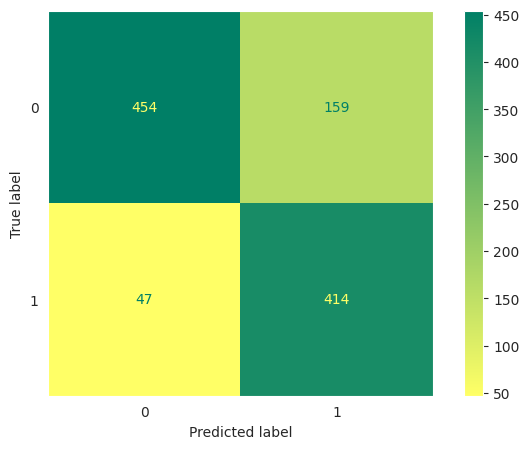

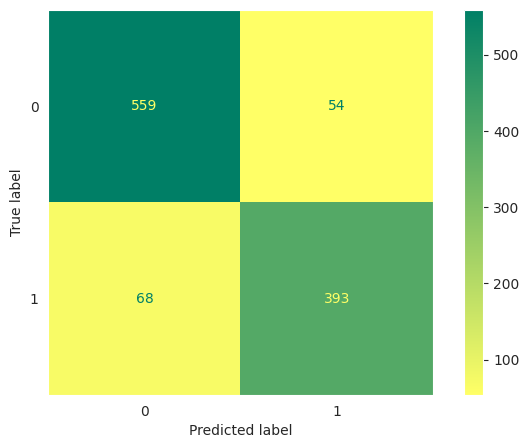

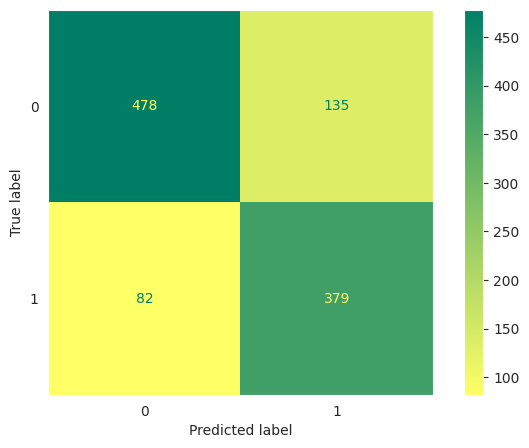

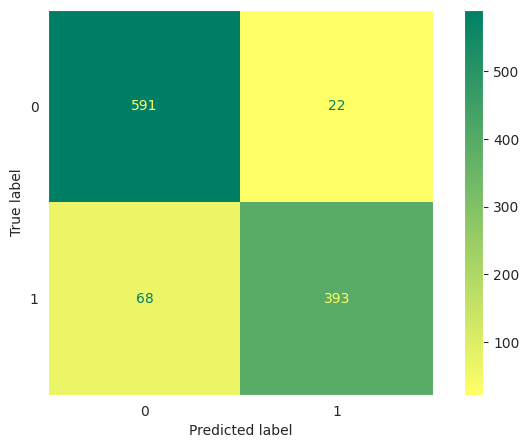

In [52]:
for modelo_numero, modelo in enumerate(modelos):
    teste_modelo(modelo_numero, (test_sequences if modelo_numero == 6 else X_test))
    print(modelos_nome[modelo_numero] + ": ")
    print(relatorios[modelo_numero])

In [53]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

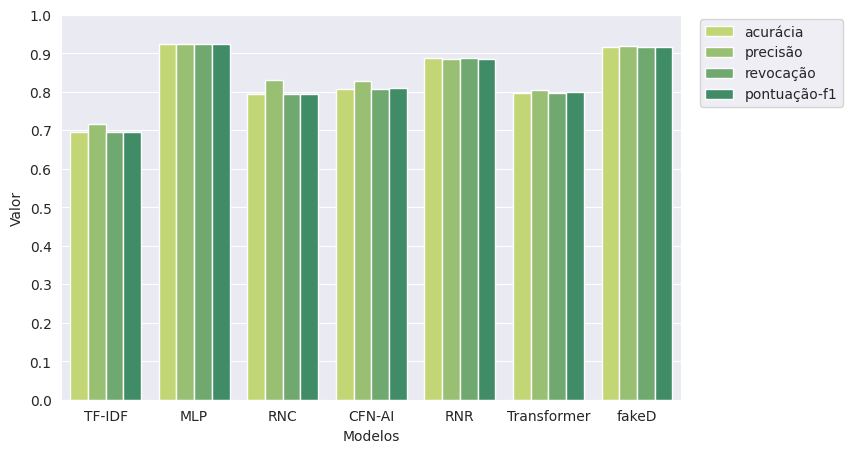

In [54]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

# plt.title('Medidas de avaliação dos modelos - Dados de teste')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

plt.legend(loc=(1.03, 0.76));